In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import jv, kv


In [171]:
# load unpolarized dipole data
unpolar_input_file = '/Users/brandonmanley/Desktop/PhD/rcbkdipole/build/bin/dipole_data/unpolarized_dipole_xmin0.010000_xmax0.000001.dat'
Ndipole_df = pd.read_csv(unpolar_input_file, sep=r'\s+', header=None, names=['xBj', 'ln(r)', 'N[ln(r)]'])


# load polarized data
# delta = 0.05
# dstr = str(delta)[2:]
# # polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones/'
# # polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
# polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones_rc/'
# polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'_rc.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
# polar_data_files = [np.loadtxt(ifile) for ifile in polar_input_files]

# def to_array(data_files):
#     dipoles = []
#     for is10, s10_row in enumerate(data_files[0]):
#         for ieta, eta in enumerate(s10_row):
#             dipole_values = [ifile[is10, ieta] for ifile in data_files]
#             dipoles.append([(is10+1)*delta, (ieta+1)*delta] + dipole_values)
#     return dipoles

# pdipole_dfs = pd.DataFrame(to_array(polar_data_files), columns = ['s10', 'eta', 'Q', 'G2', 'I3', 'I4', 'I5'])


# load polarized data (w/o cutoff)
# delta = 0.1
# dstr = str(delta)[2:]
# polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones_nocutoff_rc/'
# polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'_nocutoff_rc.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
# polar_data_files = [np.loadtxt(ifile) for ifile in polar_input_files]

delta = 0.1
dstr = str(delta)[2:]
polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones_nocutoff/'
polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'_nocutoff.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
polar_data_files = [np.loadtxt(ifile) for ifile in polar_input_files]

def to_array(data_files):

    nsteps = len(data_files[0])
    s10_range = np.arange(-nsteps + 1, nsteps)
    eta_range = np.arange(nsteps)
    
    dipoles = []
    for is10 in s10_range:
        for ieta in eta_range:
            if ieta > is10 and ieta < is10+nsteps: 
                dipoles.append([is10*delta, ieta*delta] + [idipole[is10-ieta+nsteps, ieta] for idipole in data_files])
            else: 
                dipoles.append([is10*delta, ieta*delta] + [1 for idipole in data_files])
            
    return dipoles

pdipole_dfs = pd.DataFrame(to_array(polar_data_files), columns = ['s10', 'eta', 'Q', 'G2', 'I3', 'I4', 'I5'])


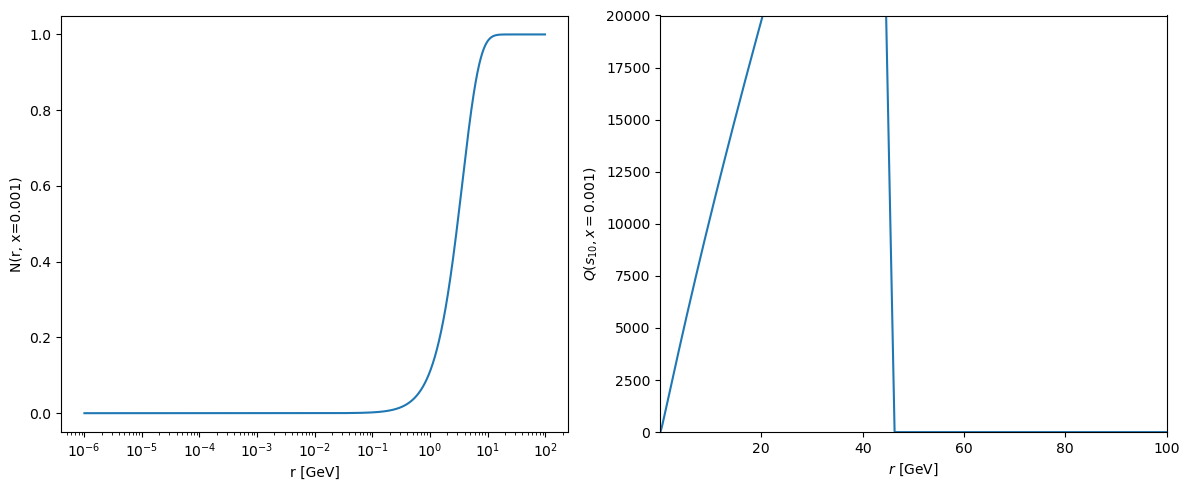

In [173]:
# to make sure we imported correctly, let's plot the dipoles as a function of r (N) and s_{10} (PDAs)

lambdaIR = 1  # IR cutoff in GeV

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

N_test = Ndipole_df[np.isclose(Ndipole_df['xBj'], 0.001, atol=1e-7)]
axes[0].plot(np.exp(N_test['ln(r)']), N_test['N[ln(r)]'])
axes[0].semilogx()
axes[0].set_xlabel('r [GeV]')
axes[0].set_ylabel('N(r, x=0.001)')


bas = np.sqrt((3)/(2*np.pi))
test_eta = np.sqrt((3.0)/(2*np.pi))*np.log(10/0.01)
Q_test = pdipole_dfs[np.isclose(pdipole_dfs['eta'], test_eta, atol=delta*0.5)]
# axes[1].plot((1/lambdaIR)*np.exp(-Q_test['s10']*0.5), np.log(np.abs(Q_test['Q'])))
axes[1].plot((1/lambdaIR)*np.exp((-Q_test['s10']*0.5)/bas), Q_test['Q'])
# axes[1].semilogx()
# axes[1].set_xlabel(r'$s_{10}$')
axes[1].set_xlabel(r'$r$ [GeV]')
axes[1].set_ylabel(r'$Q(s_{10}, x = 0.001)$')
axes[1].set_xlim(0.01, 100)
axes[1].set_ylim(0,20000)

plt.tight_layout()
plt.show()


In [177]:
# define the transfroms needed for DSA



# def blend(x):
#     return (1/(1+np.exp(6*x)))-0.5

def double_bessel(pT, Q, z, xBj, indices, amp, lamIR = lambdaIR):

    ia, ib, ic, id = indices
    prefactor = ((pT/lamIR)**ic)*(((Q*np.sqrt(z*(1-z)))/lamIR)**id)

    # polarized dipoles
    if amp != 'N':
        # bas = np.sqrt((0.25*3.0)/(2*np.pi))
        bas = np.sqrt(3/(2*np.pi))
        prefactor *= (1/(2*bas))

        # select A(s_{10}, \eta = \eta(xBj))
        target_eta = round((bas/delta)*np.log((Q**2)/(xBj*(lamIR**2))))*delta
        dipole = pdipole_dfs[np.isclose(pdipole_dfs['eta'], target_eta, atol=delta*0.5)][['s10', amp]]

    # unpolarized dipole
    else:
        # select N(r, x = xBj)
        dipole = Ndipole_df[np.isclose(Ndipole_df['xBj'], xBj, atol=1e-7)]

    
    # riemann sum for integral over r or s_{10}
    sum = 0
    for _, irow in dipole.iterrows():

        if amp != 'N':
            u = -irow['s10']*(1/(2*bas))
            amp_value = irow[amp]
            # amp_value *= 0.00001
            size = delta

            # stop after r = 10 GeV
            if irow['s10'] < bas*(-4.6): amp_value = 0

            
        else: 
            u = irow['ln(r)']
            amp_value = irow['N[ln(r)]']
            size = 0.01   # from evolution code

        # print(u)
        
        sum += size*np.exp(u*(2+ic+id))*jv(ia, (pT/lamIR)*np.exp(u))*kv(ib, (Q/lamIR)*np.sqrt(z*(1-z))*np.exp(u))*amp_value


    # print(sum)
    # freeze amp and keep adding sum
    # if amp != 'N':
    #     s10_min, amp_IR = tuple(dipole.loc[dipole.index[0], ['s10', amp]])
    #     # amp_IR *= 0.0000001
    #     # print(s10_min, amp_IR)
    #     for is10 in range(100):
    #         u = -(s10_min - is10*delta)*(1/(2*bas))
    #         amp_value = amp_IR*(1+blend(-u))
    #         # print(u)
    #         sum += size*np.exp(u*(2+ic+id))*jv(ia, (pT/lamIR)*np.exp(u))*kv(ib, (Q/lamIR)*np.sqrt(z*(1-z))*np.exp(u))*amp_value
    #         # print(sum)
            
                        
    return prefactor*sum
    

In [179]:
# compute db transform 

pT_values = np.linspace(0,30,100)
test_Q2 = np.sqrt(5)
test_z = 0.1
testN = [double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'N') for ipT in pT_values]
testQ = [double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'Q') for ipT in pT_values]



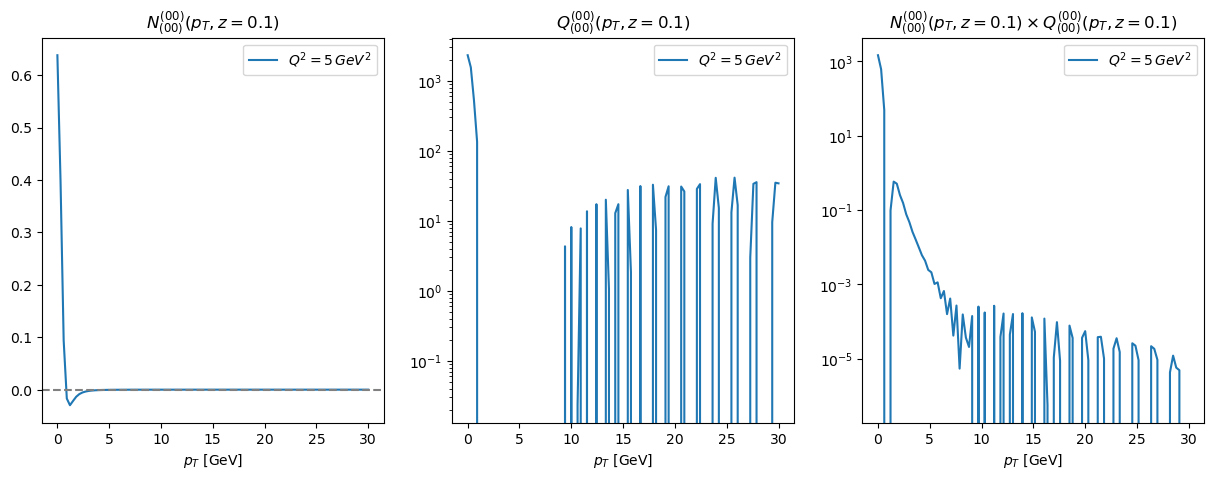

In [181]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(pT_values, testN, label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$N_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[0].legend()
# axes[0].semilogy()

axes[1].plot(pT_values, testQ, label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$Q_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[1].legend()
axes[1].semilogy()

axes[2].plot(pT_values, np.array(testN)*np.array(testQ), label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[2].axhline(y=0, color='grey', linestyle='--')
axes[2].semilogy()
axes[2].set_xlabel(r'$p_{T}$ [GeV]')
axes[2].set_title(fr'$N_{{(00)}}^{{(00)}}(p_T, z={test_z})\times Q_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[2].legend()

# plt.plot(pT_values, N_pTs[1], label = "Q, a,b = 1,0")
# plt.plot(pT_values, N_pTs[2], label = "a,b = 0,1")
# plt.plot(pT_values, N_pTs[3], label = "a,b = 1,1")
# plt.legend()
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()

In [461]:
# define functions needed for DSA

def A_TT(pT, Q, z, xBj):

    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')

    return ((1 - 2*z)**2)*Q_11 + 2*(z**2 + (1-z)**2)*G2_11

def B_TT(pT, Q, z, xBj):
    
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    Q_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    G2_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'G2')
    
    I3_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I3')
    I3_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I3')
    
    I4_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I4')
    I4_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'I4')
    I4_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I4')
    
    I5_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I5')
    I5_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I5')
    I5_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I5')

    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    N_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'N')

    b_TT = 0.5*((1-2*z)**2)*N_01_10*Q_11
    b_TT += (z**2 + (1-z)**2)*N_01_10*G2_11 + N_11*(0.5*Q_11 + I3_11 - I3_01_10)
    b_TT += (z**2 + (1-z)**2)*N_11*(Q_21_10 + 2*G2_21_10 + I4_21_10 + I4_10_01 - I5_11 + I5_10_01 + I5_01_10)

    return (1-(2*z))*b_TT


def A_LT(pT, Q, z, xBj):
    
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    Q_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')

    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')

    return (1- 2*z)*(N_00*(2*G2_11 - Q_11) - N_11*Q_00)

    
def B_LT(pT, Q, z, xBj):
    
    Q_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'Q')
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    Q_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'Q')
    Q_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    G2_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'G2')
    
    I3_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I3')
    I3_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I3')
    I3_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'I3')
    
    I4_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I4')
    I4_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'I4')
    I4_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I4')
    
    I5_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I5')
    I5_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I5')
    I5_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I5')

    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    N_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'N')
    N_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'N')

    b_LT = N_00*(I3_11 - I3_01_10)
    b_LT += N_11*I3_10_10 
    b_LT += (z**2 + (1-z)**2)*N_00*(Q_01_10 - Q_11)
    b_LT -= (z**2 + (1-z)**2)*N_11*Q_10_10 
    b_LT -= 0.5*((1- 2*z)**2)*N_10_10*Q_11
    b_LT -= 0.5*((1- 2*z)**2)*(N_11 - N_01_10)*Q_00
    b_LT += ((1- 2*z)**2)*N_00*(3*G2_11 - 2*G2_01_10 + I4_21_10 + I4_10_01 - I5_11 + I5_01_10 + I5_10_01)
    b_LT += ((1- 2*z)**2)*N_10_10*G2_11
    
    return b_LT


def C_LT(pT, Q, z, xBj):
    
    Q_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'Q')
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    G2_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'G2')
    G2_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'G2')
    
    I3_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I3')
    
    I4_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I4')
    I4_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I4')
    I4_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'I4')
    I4_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I4')
    I4_11_20 = double_bessel(pT, Q, z, xBj, [1,1,2,0], 'I4')
    I4_00_11 = double_bessel(pT, Q, z, xBj, [0,0,1,1], 'I4')
    I4_11_11 = double_bessel(pT, Q, z, xBj, [1,1,1,1], 'I4')
    I4_00_20 = double_bessel(pT, Q, z, xBj, [0,0,2,0], 'I4')
    
    I5_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I5')
    I5_11_20 = double_bessel(pT, Q, z, xBj, [1,1,2,0], 'I5')
    I5_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I5')
    I5_00_11 = double_bessel(pT, Q, z, xBj, [0,0,1,1], 'I5')
    I5_11_11 = double_bessel(pT, Q, z, xBj, [1,1,1,1], 'I5')
    I5_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'I5')
    I5_00_20 = double_bessel(pT, Q, z, xBj, [0,0,2,0], 'I5')

    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')

    c_LT = (z**2 + (1-z)**2)*N_11*Q_11
    c_LT -= N_00*I3_11
    c_LT += 0.5*((1- 2*z)**2)*N_11*Q_00
    c_LT += ((1- 2*z)**2)*N_00*(G2_01_10 - 3*G2_11 - I4_10_10 - 2*I4_11 + 2*I4_01_10 - I4_11_20 - I4_10_01 + I4_00_11 + I5_11 - I5_11_20 - I5_10_01 + I5_00_11)
    c_LT += ((1- 2*z)**2)*N_11*(G2_10_10 + I4_11_11 + I4_00_20 + I5_11_11 - I5_10_10 + I5_00_20)
    
    return c_LT



# unpolarized amps
def A_TT_unpolar(pT, Q, z, xBj):
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    return (z**2 + (1-z)**2)*(N_11**2)

def A_LL_unpolar(pT, Q, z, xBj):
    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')
    return (z**2 + (1-z)**2)*(N_00**2)




In [463]:
# compute DSA for various kinematics
pT_values = np.linspace(1, 20, 100)

# vary Q2, xBj, z
# Qs = [np.sqrt(5), np.sqrt(10), np.sqrt(20)]
Qs = [np.sqrt(10)]
xBjs = [0.01, 0.001, 0.0001]
zs = [0.1, 0.2, 0.3, 0.4, 0.5]

varied_data = {}
varied_data['Q2'] = {func.__name__: [[func(pT, Q, zs[-2], xBjs[0]) for pT in pT_values] for Q in Qs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
# varied_data['xBj'] = {func.__name__: [[func(pT, Qs[0], zs[0], xBj) for pT in pT_values] for xBj in xBjs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
# varied_data['z'] = {func.__name__: [[func(pT, Qs[0], z, xBjs[0]) for pT in pT_values] for z in zs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}



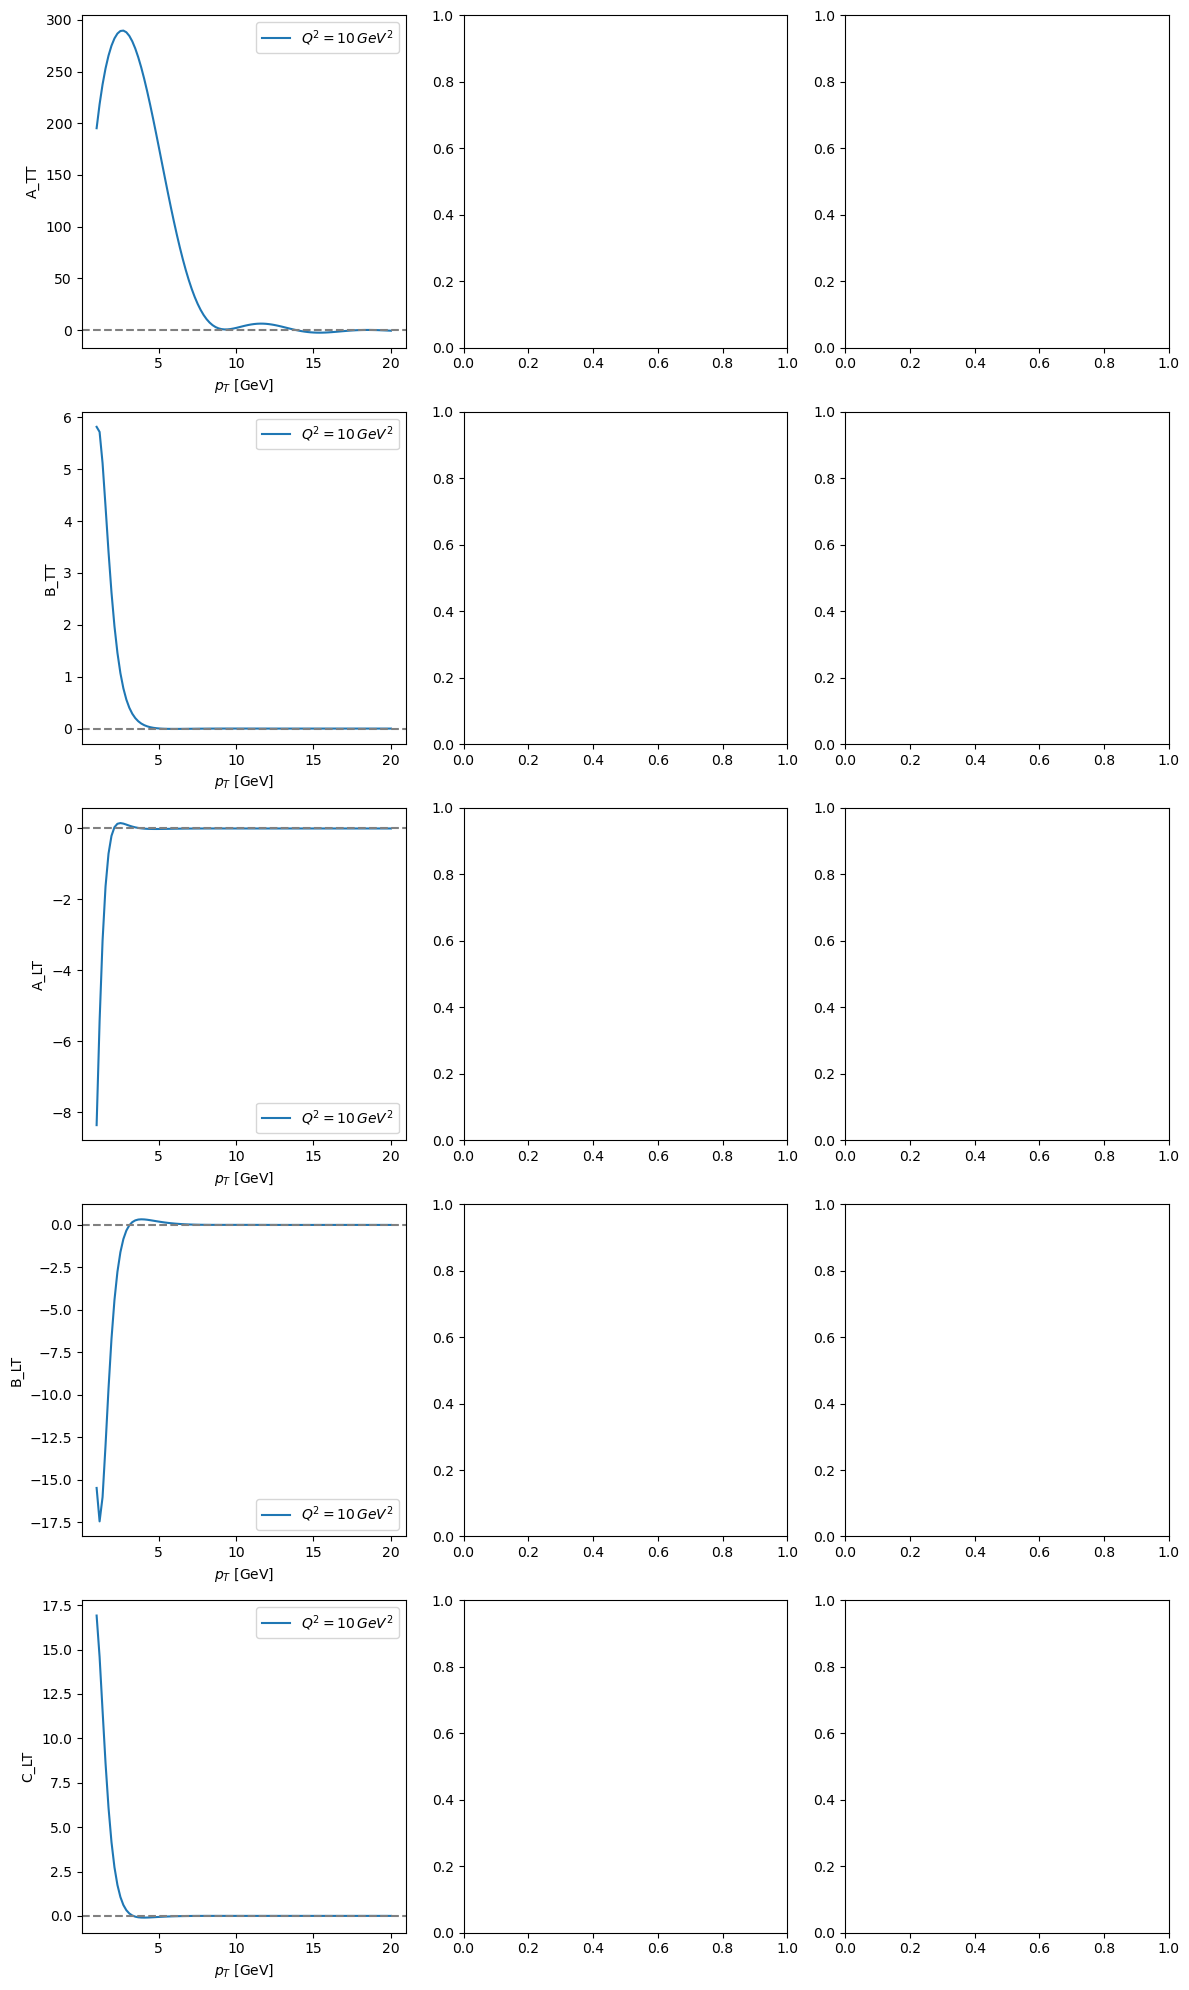

In [464]:
# plot variations

# amplitude plots
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for idist, dist in enumerate(['A_TT', 'B_TT', 'A_LT', 'B_LT', 'C_LT']):
    axes[idist,0].set_ylabel(dist)
    
    for iQ, Q in enumerate(Qs):
        axes[idist,0].plot(pT_values, varied_data['Q2'][dist][iQ], label = fr'$Q^2={round(Q**2)}\,GeV^2$')
        axes[idist,0].legend()
        axes[idist,0].axhline(y=0, color='grey', linestyle='--')
        axes[idist,0].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,0].semilogy()

    # for ixBj, xBj in enumerate(xBjs):
    #     axes[idist,1].plot(pT_values, varied_data['xBj'][dist][ixBj], label = fr'$x={xBj}$')
    #     axes[idist,1].legend()
    #     axes[idist,1].axhline(y=0, color='grey', linestyle='--')
    #     axes[idist,1].set_xlabel(r'$p_T$ [GeV]')

    # for iz, z in enumerate(zs):
    #     axes[idist,2].plot(pT_values, varied_data['z'][dist][iz], label = fr'$z={z}$')
    #     axes[idist,2].legend()
    #     axes[idist,2].axhline(y=0, color='grey', linestyle='--')
    #     axes[idist,2].set_xlabel(r'$p_T$ [GeV]')

plt.tight_layout()
plt.show()


In [415]:
# compute <1> and <cos\phi> 

test_1 = [A_TT(ipT, test_Q2, test_z, 0.01)/A_TT_unpolar(ipT, test_Q2, test_z, 0.01) for ipT in pT_values]
test_cos = [B_TT(ipT, test_Q2, test_z, 0.01)/A_TT_unpolar(ipT, test_Q2, test_z, 0.01) for ipT in pT_values]


/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_49868/2430333947.py:3: RuntimeWarning: invalid value encountered in scalar divide
  test_1 = [A_TT(ipT, test_Q2, test_z, 0.01)/A_TT_unpolar(ipT, test_Q2, test_z, 0.01) for ipT in pT_values]
/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_49868/2430333947.py:4: RuntimeWarning: invalid value encountered in scalar divide
  test_cos = [B_TT(ipT, test_Q2, test_z, 0.01)/A_TT_unpolar(ipT, test_Q2, test_z, 0.01) for ipT in pT_values]


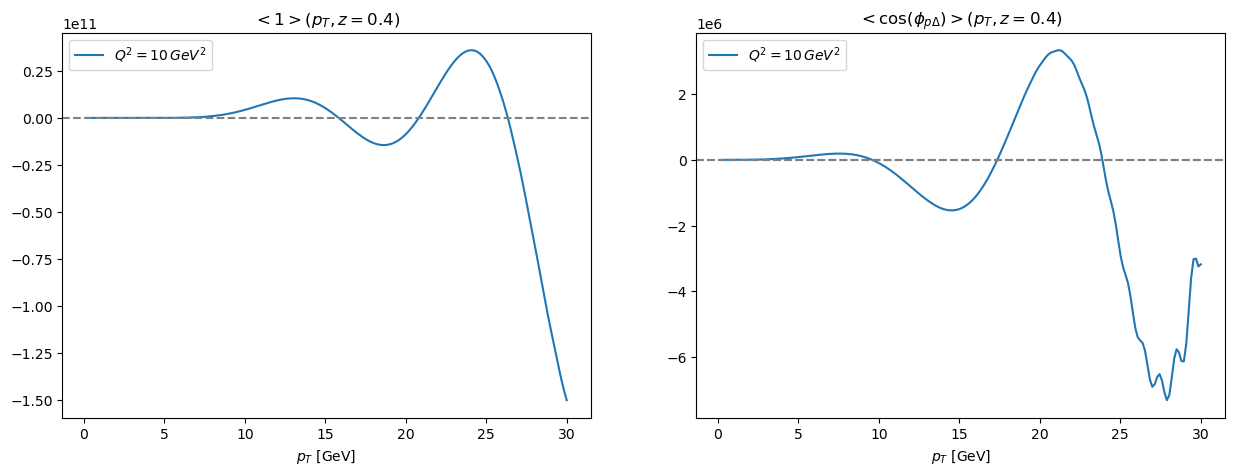

In [416]:
# plot azimuthal moments 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(pT_values, test_1, label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$<1>(p_T, z={test_z})$')
axes[0].legend()
# axes[0].semilogy()

axes[1].plot(pT_values, test_cos, label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$<\cos (\phi_{{p \Delta}})>(p_T, z={test_z})$')
axes[1].legend()
# axes[1].semilogy()


# plt.plot(pT_values, N_pTs[1], label = "Q, a,b = 1,0")
# plt.plot(pT_values, N_pTs[2], label = "a,b = 0,1")
# plt.plot(pT_values, N_pTs[3], label = "a,b = 1,1")
# plt.legend()
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()